In [1]:
ENV["GKS_ENCODING"] = "utf-8"
using Plots
using LadderDGA
using Logging

io = stdout
metafmt(level::Logging.LogLevel, _module, group, id, file, line) = Logging.default_metafmt(level, nothing, group,     id, nothing, nothing)
logger = ConsoleLogger(io, Logging.Info, meta_formatter=metafmt, show_limited=true, right_justify=0)
global_logger(logger);

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


# Setup and read DMFT quantities

In [2]:
cfg_file = "/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0/config_j.toml";

mP, sP, env, kGrids, qGridLoc, freqRed_map, freqList, freqList_min, parents, ops, nFermi, nBose, shift, base, offset = readConfig(cfg_file)
kG = kGrids[1]
νGrid, sumHelper_f, impQ_sp, impQ_ch, GImp_fft, GLoc_fft, Σ_loc, FUpDo, gImp, gLoc = setup_LDGA(kG, freqList, mP, sP, env);

[ Info: Reading Inputs...
[ Warning: TODO: check beta consistency, config <-> g0man, chi_dir <-> gamma dir
[ Info: setting usable ranges of sp and ch channel from 13:29 and 13:29 to the same range of 13:29
┌ Info: Inputs Read. Starting Computation.
│ Local susceptibilities with ranges are:
│ χLoc_sp(13:29) = 0.1878, χLoc_ch(13:29) = 0.1175 
└ sum χupup check (fit, tail sub, tail sub + fit, expected): 0.1526666253073471 ?≈? 0.15266662530734712 ?=? 0.15266662530734712 ?≈? 0.25"


In [3]:
iνₙ = LadderDGA.iν_array(mP.β, 0:(sP.n_iν-1))
iνₙ, GImp    = LadderDGA.readGImp(env.inputDir * "/gm_wim", only_positive=true)
ϵₖ, Vₖ, μ    = LadderDGA.read_anderson_parameters(env.inputDir * "/hubb.andpar");
E_kin_ED, E_pot_ED  = LadderDGA.calc_E_ED(iνₙ[1:20], ϵₖ, Vₖ, GImp[1:20], mP)
E_kin_ED_large, E_pot_ED_large  = LadderDGA.calc_E_ED(iνₙ[1:5000], ϵₖ, Vₖ, GImp[1:5000], mP)

(-0.7618733847649715, 0.2035812924974587)

In [4]:
ep, ek = LadderDGA.calc_E(Σ_loc[1:sP.n_iν], kG, mP, sP);

In [5]:
usable_ω = intersect(impQ_sp.usable_ω, impQ_ch.usable_ω);

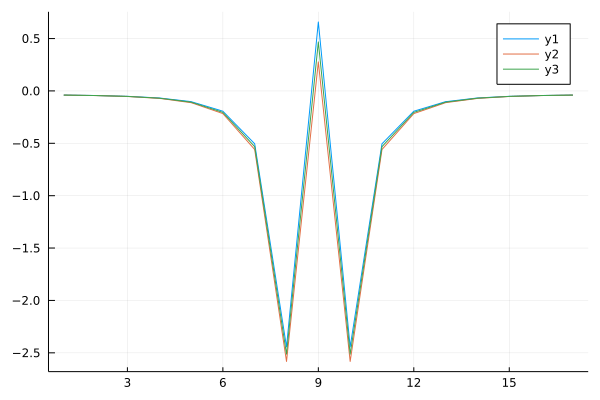

In [6]:
subtract_tail = LadderDGA.subtract_tail
iωn = 1im .* 2 .* (-sP.n_iω:sP.n_iω)[usable_ω] .* π ./ mP.β
plot(real(subtract_tail(impQ_sp.χ_ω[usable_ω], E_kin_ED_large,iωn)))
plot!(real(subtract_tail(impQ_ch.χ_ω[usable_ω], E_kin_ED_large, iωn )))
plot!(real(subtract_tail(0.5*(impQ_sp.χ_ω .+ impQ_ch.χ_ω )[usable_ω], E_kin_ED_large, iωn)))

In [7]:
# "local" correction quantities
bubbleLoc = calc_bubble(νGrid, GImp_fft, qGridLoc, mP, sP);
locQ_sp = calc_χ_trilex(impQ_sp.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, mP.U, mP, sP);
locQ_ch = calc_χ_trilex(impQ_ch.Γ, bubbleLoc, qGridLoc, νGrid, sumHelper_f, -mP.U, mP, sP);
Σ_ladderLoc = calc_Σ(locQ_sp, locQ_ch, bubbleLoc, GImp_fft, FUpDo,
                     qGridLoc, sumHelper_f, mP, sP)
Σ_ladderLoc = Σ_ladderLoc .+ mP.n * mP.U/2.0;

# ladder quantities
bubble = calc_bubble(νGrid, GLoc_fft, kG, mP, sP);
nlQ_sp = calc_χ_trilex(impQ_sp.Γ, bubble, kG, νGrid, sumHelper_f, mP.U, mP, sP);
nlQ_ch = calc_χ_trilex(impQ_ch.Γ, bubble, kG, νGrid, sumHelper_f, -mP.U, mP, sP);
nlQ_sp_nλ = deepcopy(nlQ_sp)
nlQ_ch_nλ = deepcopy(nlQ_ch)

λ_sp, λ_spch  = λ_correction!(impQ_sp, impQ_ch, FUpDo, Σ_loc, Σ_ladderLoc, nlQ_sp, nlQ_ch, bubble, GLoc_fft, kG, mP, sP)

Σ_ladder = calc_Σ(nlQ_sp, nlQ_ch, bubble, GLoc_fft, FUpDo, kG, sumHelper_f, mP, sP)
Σ_ladder_corrected = Σ_ladder .- Σ_ladderLoc .+ Σ_loc[1:size(Σ_ladder,1)];

┌ Info: Computing λsp corrected χsp, using 
│   sP.χFillType = lambda_χ_fill::ChiFillType = 1
└    as fill value outside usable ω range. = " as fill value outside usable ω range."
[ Warning: currently using min(usable_sp, usable_ch) = min(14:28,14:28) = 14:28 for all calculations. relax this?
┌ Info: Found usable intervals for non-local susceptibility of length 
│ sp: 14:28, length: 15
│ ch: 14:28, length: 15
│ usable: 14:28, length: 15
└ χch sum = 0.15011239537340934, rhs = 0.15522085524128484
┌ Info: found 
│   χ_min = 0.0752561618344813
└   ". Looking for roots in intervall $(int)" = ". Looking for roots in intervall [0.0752561618344813, 2.7419228285011483]"
┌ Info: Found λsp 
└   λsp = 2.004832855248174
[ Info: new lambda correction: λsp=0.0 and λch=0.0


In [8]:
using JLD2
f = load("/home/julian/Hamburg/lDGA_shift_tests/data/20_20_s0_b12_u1.0/ED_out.jld2")
1 ./ f["g0"]

82-element Vector{ComplexF64}:
                 0.5 + 1.0360315089im
  0.4999999999999999 + 1.3828203080999997im
                 0.5 + 1.7933107586im
                 0.5 + 2.2272920729im
 0.49999999999999994 + 2.6839631024999995im
                 0.5 + 3.1579025118im
                 0.5 + 3.6439583135im
                 0.5 + 4.138478551im
                 0.5 + 4.6390227495im
                 0.5 + 5.1439585951im
                 0.5 + 5.6521737228im
  0.5000000000000001 + 6.162892155000001im
  0.5000000000000001 + 6.675559679900001im
                     ⋮
  0.4999999999999999 + 36.93724330679999im
                 0.5 + 37.4605133402im
                 0.5 + 37.9837924284im
                 0.5 + 38.5070802027im
  0.5000000000000001 + 39.030376313800005im
  0.5000000000000001 + 39.55368043130001im
                 0.5 + 40.0769922415im
                 0.5 + 40.6003114475im
                 0.5 + 41.1236377669im
  0.4999999999999999 + 41.64697093179999im
                 0.5 + 4

In [9]:
f["gImp"]

82-element Vector{ComplexF64}:
 2.7e-15 - 0.9415160644983689im
 2.0e-16 - 0.6986004731971177im
     0.0 - 0.5405279230177961im
     0.0 - 0.4375374196050955im
     0.0 - 0.3648821447273189im
     0.0 - 0.3113660820642375im
    -0.0 - 0.2706822812558286im
     0.0 - 0.2389186755243426im
     0.0 - 0.2135440480327034im
     0.0 - 0.192869156131822im
     0.0 - 0.1757347391721603im
     0.0 - 0.1613244588134147im
     0.0 - 0.1490497467019732im
         ⋮
     0.0 - 0.0270680055799603im
     0.0 - 0.0266900386975433im
     0.0 - 0.0263224739731441im
     0.0 - 0.0259648881313416im
     0.0 - 0.0256168805376029im
     0.0 - 0.0252780717055006im
     0.0 - 0.0249481019204214im
     0.0 - 0.0246266299693028im
     0.0 - 0.0243133319669952im
     0.0 - 0.0240079002707877im
     0.0 - 0.0237100424754708im
     0.0 - 0.0234194804820537im

In [10]:
function Base.show(io::IO, m::SimulationParameters)
    compact = get(io, :compact, false)
    if !compact
        println(io, "B/F range    : $(m.n_iω)/$(m.n_iν) $(m.shift ? "with" : "without") shifted fermionic frequencies")
        println(io, "   ωsum type = $(m.ωsum_type) $(m.fullChi ? "with" : "without") full χ(ω) range computation (filled as $(m.χFillType), $(m.dbg_full_eom_omega ? "with" : "without") full ω range in EoM.")
        println(io, "B/F sum type : $(m.tc_type_b)/$(m.tc_type_f)")
        println(io, "   $(100*m.usable_prct_reduction) % reduction of usable range and ω smoothing $(m.usable_prct_reduction)")
        println(io, "λ-Correction : $(m.λc_type) with rhs $(m.λ_rhs)")
    else
        print(io, "SimulationParams[nB=$m.n_iω, nF=m.n_iν, shift=m.shift]")
    end
    #show(io, sP)
end

function Base.show(io::IO, ::MIME"text/plain", m::SimulationParameters)
 
    println(io, "LadderDGA.jl SimulationParameters:")
    show(io, m)
end

function Base.show(io::IO, m::ModelParameters)
    compact = get(io, :compact, false)

    if !compact
        println(io, "ModelParameters[U=$m.U, μ=$m.μ, β=$m.β, n=$m.n]")
    else
        println(io, "ModelParameters[U=$m.U, μ=$m.μ, β=$m.β, n=$m.n]")
    end
    #show(io, sP)
end

function Base.show(io::IO, ::MIME"text/plain", m::ModelParameters)
 
    println(io, "LadderDGA.jl ModelParameters:")
    #show(io, m)
end

#mP

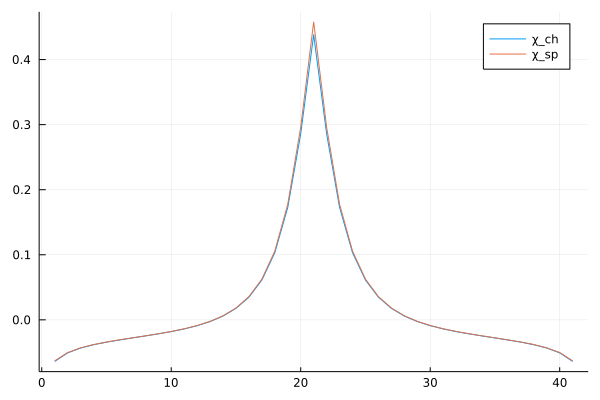

In [11]:
χch_ω = LadderDGA.kintegrate(kG,nlQ_ch.χ, dim=2)[:,1]
χsp_ω = LadderDGA.kintegrate(kG,nlQ_sp.χ, dim=2)[:,1]
plot(real.(χch_ω), label="χ_ch")
plot!(real.(χsp_ω), label="χ_sp")

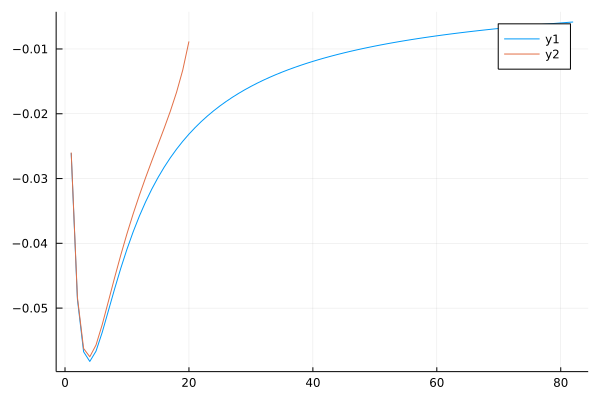

In [12]:
plot(imag(Σ_loc))
plot!(imag(Σ_ladderLoc))

In [13]:
sum(LadderDGA.kintegrate(kG,nlQ_ch.χ, dim=2)[15:27,1])/mP.β

0.14913334761187444 - 4.131813869484289e-9im

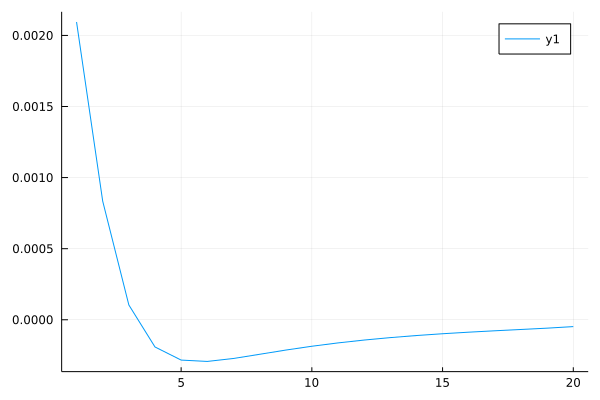

In [14]:
plot(real(Σ_ladder_corrected[:,1]))

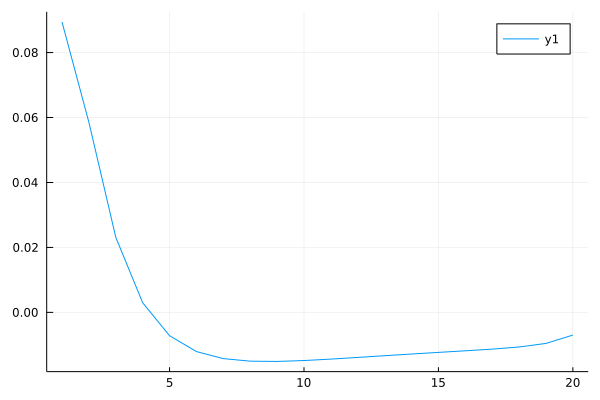

In [15]:
plot(imag(Σ_ladder_corrected[:,1]))

In [16]:
kintegrate(kGrid, sum_freq(nlQ_ch.χ[nlQ_ch.usable_ω,:], [1], LadderDGA.Naive(), mP.β)[1,:])[1]

LoadError: UndefVarError: kintegrate not defined

In [17]:
Σ = Σ_ladder_corrected
iν_array = LadderDGA.iν_array
G_from_Σ = LadderDGA.G_from_Σ
flatten_2D = LadderDGA.flatten_2D
kintegrate = LadderDGA.kintegrate
kGrid = kG
# = LadderDGA.

νmax = size(Σ,1)
νGrid = 0:(νmax-1)
iν_n = iν_array(mP.β, νGrid)
Σ_hartree = mP.n * mP.U/2
Σ_corr = Σ .+ Σ_hartree

E_kin_tail_c = [zeros(size(kGrid.ϵkGrid)), (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ)]
E_pot_tail_c = [zeros(size(kGrid.ϵkGrid)),
                (mP.U^2 * 0.5 * mP.n * (1-0.5*mP.n) .+ Σ_hartree .* (kGrid.ϵkGrid .+ Σ_hartree .- mP.μ))]
tail = [1 ./ (iν_n .^ n) for n in 1:length(E_kin_tail_c)]
E_pot_tail = sum(E_pot_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_kin_tail = sum(E_kin_tail_c[i]' .* tail[i] for i in 1:length(tail))
E_pot_tail_inv = sum((mP.β/2)  .* [Σ_hartree .* ones(size(kGrid.ϵkGrid)), (-mP.β/2) .* E_pot_tail_c[2]])
E_kin_tail_inv = sum(map(x->x .* (mP.β/2) .* kGrid.ϵkGrid , [1, -(mP.β) .* E_kin_tail_c[2]]))

G_corr = flatten_2D(G_from_Σ(Σ_corr, kGrid.ϵkGrid, νGrid, mP));
E_pot = real.(G_corr .* Σ_corr .- E_pot_tail);
E_kin = kGrid.ϵkGrid' .* real.(G_corr .- E_kin_tail);

E_pot = [kintegrate(kGrid, 2 .* sum(E_pot[1:i,:], dims=[1])[1,:] .+ E_pot_tail_inv) for i in 1:νmax]
E_kin = [kintegrate(kGrid, 4 .* sum(E_kin[1:i,:], dims=[1])[1,:] .+ E_kin_tail_inv) for i in 1:νmax];

In [18]:
Σ_ladder_corrected[:,1]

20-element Vector{ComplexF64}:
   0.0020946414157101967 + 0.08941610441336757im
   0.0008344165038528528 + 0.05851923572531004im
  0.00010401596668274671 + 0.023108215498518422im
  -0.0001915168792324673 + 0.002967222968451172im
  -0.0002837783264466043 - 0.007195395118547138im
  -0.0002932513715685481 - 0.01206796519281176im
  -0.0002724912402685131 - 0.014236030703740188im
 -0.00024307829145053805 - 0.015022434325645227im
  -0.0002134095647263745 - 0.015102712849326641im
  -0.0001864594220662985 - 0.014827833180518168im
 -0.00016297929755371143 - 0.014383687651942728im
 -0.00014286606602342822 - 0.0138700521295188im
  -0.0001257159573261335 - 0.013340205326254517im
 -0.00011106996592957774 - 0.012820816899626206im
   -9.846664377322067e-5 - 0.012320746684764256im
   -8.746690400307511e-5 - 0.011831281909713946im
   -7.763603747779069e-5 - 0.011314119132573762im
   -6.846081492106748e-5 - 0.010659502566417728im
  -5.9158995437069706e-5 - 0.009551485072294072im
   -4.818475078161022e-5

In [19]:
nlQ_ch.χ[1,:]

56-element Vector{ComplexF64}:
 -0.06469998090549667 + 9.163449410811939e-11im
 -0.06420788020439658 + 9.208965801291775e-11im
 -0.06371943738105869 + 9.255566914072675e-11im
 -0.06323431104493722 + 9.303294654789808e-11im
 -0.06402046264283481 + 9.22650646636625e-11im
 -0.06353338805509742 + 9.273526271452363e-11im
 -0.06304950085648114 + 9.321689315676872e-11im
 -0.06334785035992657 + 9.291647245751066e-11im
 -0.06286515343549211 + 9.34025217656599e-11im
 -0.06268125027038443 + 9.358985854707086e-11im
  -0.0642078802043966 + 9.20896580465114e-11im
 -0.06371943738105869 + 9.255566915836562e-11im
 -0.06323431104493722 + 9.303294656713635e-11im
                      ⋮
 -0.06432172681585548 + 9.197421275493207e-11im
 -0.06531118958909295 + 9.107989345544634e-11im
 -0.06481441459156521 + 9.152187317385411e-11im
 -0.06462524771940886 + 9.169219134636735e-11im
 -0.06481441459156521 + 9.15218731986437e-11im
 -0.06531118958909295 + 9.107989349591536e-11im
 -0.06592836656370028 + 9.05413205238

In [20]:
kGrid.ϵkGrid

56-element Vector{Float64}:
 -1.224744871391589
 -1.146776385837511
 -1.068807900283433
 -0.990839414729355
 -0.9426522406055795
 -0.8646837550515015
 -0.7867152694974234
 -0.66055960981957
 -0.582591124265492
 -0.3784669790335604
 -0.6903409212498726
 -0.6123724356957945
 -0.5344039501417165
  ⋮
  0.66055960981957
  0.330279804909785
  0.408248290463863
  0.6123724356957945
  0.8646837550515015
  1.068807900283433
  0.408248290463863
  0.48621677601794105
  0.6903409212498726
  0.9426522406055795
  1.146776385837511
  1.224744871391589

In [21]:
G_corr[1,:]

56-element Vector{ComplexF64}:
  0.8019536831497229 - 0.1130686484452692im
  0.8553621684004983 - 0.12836777062093768im
  0.9161338977194822 - 0.14723454266798708im
  0.9861649414460175 - 0.17080913111675958im
  1.0310922043452937 - 0.18800856688082204im
  1.1194611135697752 - 0.22230852047468497im
  1.2242304926040823 - 0.26725759160376367im
  1.4304253202699122 - 0.37213118405852763im
  1.5999953841628984 - 0.4729691269003454im
  2.2343881906821426 - 1.0252089991901923im
  1.3702934058082343 - 0.34229247384630046im
   1.524964710721052 - 0.4291817886741239im
   1.714905053748276 - 0.5537739641290619im
                     ⋮
 -1.4130446845257965 - 0.3635563358443755im
  -2.376897747605429 - 1.2376722603746053im
 -2.0752109619922057 - 0.8674498871788459im
  -1.509608711450275 - 0.4197824058568836im
 -1.1104137685831021 - 0.21969923881041023im
 -0.9113477671513377 - 0.14685663004661426im
 -2.0814658713519583 - 0.8801939291335477im
 -1.8279350019320473 - 0.6438866650495757im
 -1.36324874

In [22]:
E_pot

20-element Vector{Vector{Float64}}:
 [1.620338769200766]
 [2.5533232932005743]
 [2.877369816743986]
 [3.0294438382013587]
 [3.1137313627126004]
 [3.1659377097324297]
 [3.2009560947160245]
 [3.2258814042709116]
 [3.2444453826181956]
 [3.258768930783175]
 [3.270134964484478]
 [3.279360254635732]
 [3.286987593013023]
 [3.2933913644993966]
 [3.298839007821714]
 [3.303529480285182]
 [3.3076209678855104]
 [3.3112586112614633]
 [3.3146216935261537]
 [3.3180530010493605]